In [ ]:
# STUDY OF SCARS IN PXP MODEL - NEEL STATE OVERLAPs ARE COMPUTED IN THE ALLOWED SUBSPACE, ENTANGLEMENT ENTROPIES ARE COMPUTED IN THE FULL HILBERT SPACE

In [ ]:
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt
from scipy.sparse import kron, identity, csr_matrix, lil_matrix
from scipy.sparse.linalg import eigsh, eigs
from scipy.optimize import curve_fit
from qutip import Qobj, ptrace
from tqdm import tqdm
from itertools import product

In [18]:
# Define the Pauli matrices
def pauli_x():
    """Pauli X matrix."""
    return np.array([[0, 1], [1, 0]])

def pauli_z():
    """Pauli Z matrix."""
    return np.array([[1, 0], [0, -1]])

# Function to construct the PXP Hamiltonian
def pxp(N, pbc=True, sparse=False):
    """
    Constructs the Hamiltonian for the PXP model.
    
    Parameters:
        N (int): Number of spins.
        pbc (bool): Whether to use periodic boundary conditions.
        sparse (bool): Whether to return a sparse matrix.
    
    Returns:
        H (numpy.ndarray): The Hamiltonian matrix.
    """
    I = np.eye(2)  # Identity matrix
    X = pauli_x()  # Pauli X matrix
    Z = pauli_z()  # Pauli Z matrix
    P = 0.5 * (I + Z)  # Projection operator

    # Initialize Hamiltonian
    H = np.zeros((2**N, 2**N), dtype=np.float64)

    # Build the Hamiltonian
    for i in range(1, N - 1):
        term = 1
        for j in range(N):
            if j == i:
                term = np.kron(term, X)
            elif j == i - 1 or j == i + 1:
                term = np.kron(term, P)
            else:
                term = np.kron(term, I)
        H += term

    # Add periodic boundary condition terms
    if pbc:
        term1 = 1
        for j in range(N):
            if j == 0:
                term1 = np.kron(term1, X)
            elif j == 1 or j == N - 1:
                term1 = np.kron(term1, P)
            else:
                term1 = np.kron(term1, I)
        H += term1

        term2 = 1
        for j in range(N):
            if j == 0 or j == N - 2:
                term2 = np.kron(term2, P)
            elif j == N - 1:
                term2 = np.kron(term2, X)
            else:
                term2 = np.kron(term2, I)
        H += term2

    return H

# Modify the function call to match the correct binary signature
def construct_pxp_hamiltonian_fixed(n_spins, pbc=True):
    """
    Constructs the PXP Hamiltonian matrix for a system of n_spins with periodic boundary conditions (PBC).
    This function follows the implementation from the notebook.
    
    Parameters:
        n_spins (int): Number of spins in the system.
        pbc (bool): Whether to use periodic boundary conditions.
    
    Returns:
        H (numpy.ndarray): The PXP Hamiltonian matrix in the constrained subspace.
        basis (list): The list of allowed basis states in binary format.
    """
    full_basis = list(product([0, 1], repeat=n_spins))  # Generate all possible states
    
    # Filter states to enforce the Rydberg blockade (no adjacent 1s)
    allowed_basis = []
    for state in full_basis:
        if pbc:  # PBC: Enforce the blockade across periodic boundaries
            if all(state[i] + state[(i + 1) % n_spins] <= 1 for i in range(n_spins)):
                allowed_basis.append(state)
        else:  # OBC: Standard adjacency check
            if all(state[i] + state[i + 1] <= 1 for i in range(n_spins - 1)):
                allowed_basis.append(state)
    
    # Map basis states to indices
    basis_size = len(allowed_basis)
    state_to_index = {state: idx for idx, state in enumerate(allowed_basis)}
    
    # Construct the full PXP Hamiltonian
    full_H = pxp(n_spins, pbc=pbc, sparse=False)
    
    # Project full Hamiltonian onto the constrained subspace
    H = np.zeros((basis_size, basis_size), dtype=float)
    for i, state_i in enumerate(allowed_basis):
        for j, state_j in enumerate(allowed_basis):
            idx_i = int("".join(map(str, state_i)), 2)
            idx_j = int("".join(map(str, state_j)), 2)
            H[i, j] = full_H[idx_i, idx_j]
    
    return H, allowed_basis

def map_to_full_hilbert_space(reduced_state, basis_states, n_spins):
    """
    Maps a reduced dimension state back to the full Hilbert space.

    Parameters:
    reduced_state : np.array
        The state vector in the reduced dimension.
    basis_states : list of tuples
        The basis states used in the reduced dimension.
    n_spins : int
        The total number of spins in the system.

    Returns:
    np.array
        The state vector in the full Hilbert space.
    """
    # Initialize the full Hilbert space vector
    full_dim = 2**n_spins
    full_hilbert_space_vector = np.zeros(full_dim, dtype=complex)

    # Map the reduced dimension state back to the full Hilbert space
    for i, state in enumerate(basis_states):
        # Convert the basis state to its index in the full Hilbert space
        full_index = int("".join(map(str, state)), 2)
        # Debugging statement
        if full_index >= full_dim:
            print(f"Error: full_index {full_index} is out of bounds for full_hilbert_space_vector with size {full_dim}")
        # Assign the value from the reduced dimension state to the full Hilbert space vector
        full_hilbert_space_vector[full_index] = reduced_state[i]

    return full_hilbert_space_vector

def entanglement_entropy(psi, subsystem_size, reduced_dim):
    """
    Computes the bipartite entanglement entropy of a pure state.
    
    Parameters:
    psi : np.array
        The wavefunction (state vector) of the reduced system.
    subsystem_size : int
        The number of qubits in subsystem A.
    total_size : int
        The total number of qubits in the system.
    reduced_dim : int
        The dimension of the reduced Hilbert space.
    
    Returns:
    float
        The von Neumann entanglement entropy S_A.
    """
    # Calculate the size of the environment
    environment_size = reduced_dim // (subsystem_size)
    
    # Reshape psi into a 2^subsystem_size x environment_size matrix
    psi_matrix = psi.reshape((subsystem_size, environment_size))
    
    # Compute the reduced density matrix rho_A = Tr_B(|psi><psi|)
    rho_A = np.dot(psi_matrix, psi_matrix.conj().T)  # Partial trace over B
    
    # Compute eigenvalues of rho_A
    eigenvalues = np.linalg.eigvalsh(rho_A)
    
    # Filter out zero eigenvalues to avoid numerical issues in log calculation
    eigenvalues = eigenvalues[eigenvalues > 0]
    
    # Compute von Neumann entropy S_A = -Tr(rho_A log rho_A)
    entropy = -np.sum(eigenvalues * np.log2(eigenvalues))
    
    return entropy

def entanglement_entropy_full(psi, subsystem_size, total_size):
    """
    Computes the bipartite entanglement entropy of a pure state.
    
    Parameters:
    psi : np.array
        The wavefunction (state vector) of the full system.
    subsystem_size : int
        The number of qubits in subsystem A.
    total_size : int
        The total number of qubits in the system.
    
    Returns:
    float
        The von Neumann entanglement entropy S_A.
    """
    # Calculate the size of the environment
    environment_size = total_size - subsystem_size
    
    # Reshape psi into a 2^subsystem_size x 2^environment_size matrix
    psi_matrix = psi.reshape((2**subsystem_size, 2**environment_size))
    
    # Compute the reduced density matrix rho_A = Tr_B(|psi><psi|)
    rho_A = np.dot(psi_matrix, psi_matrix.conj().T)  # Partial trace over B
    
    # Compute eigenvalues of rho_A
    eigenvalues = np.linalg.eigvalsh(rho_A)
    
    # Filter out zero eigenvalues to avoid numerical issues in log calculation
    eigenvalues = eigenvalues[eigenvalues > 0]
    
    # Compute von Neumann entropy S_A = -Tr(rho_A log rho_A)
    entropy = -np.sum(eigenvalues * np.log2(eigenvalues))
    
    return entropy

def partial_trace(rho, keep, dims):
    """Compute the partial trace of a density matrix."""
    keep_dims = np.prod([dims[i] for i in keep])
    trace_dims = np.prod([dims[i] for i in range(len(dims)) if i not in keep])
    rho = rho.reshape([keep_dims, trace_dims, keep_dims, trace_dims])
    return np.trace(rho, axis1=1, axis2=3).reshape([keep_dims, keep_dims])

def fib_num(n):
    if n <= 0:
        return 0
    elif n == 1:
        return 1
    else:
        return fib_num(n-1) + fib_num(n-2)


def fib_dim(n, pbc=True):
    if pbc:
        return fib_num(n-1) + fib_num(n+1)
    else:
        return fib_num(n+2)

In [ ]:
n_spins = 12 # Number of spins

In [ ]:
# ALLOWED HILBERT SUBSPACE, NEEL STATE OVERLAP COMPUTATION

# Reconstruct the PXP Hamiltonian with pbc in the reduced Hilbert space
H, basis_states = construct_pxp_hamiltonian_fixed(n_spins, pbc=True)
print(len(basis_states))

# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = eigh(H)
print(len(eigenvectors[0]))

subsystem_size = len(eigenvectors[:, 0]) // 2

# Compute entanglement entropy for all eigenstates in the reduced Hilbert space
entropies = [entanglement_entropy(eigenvectors[:, i], subsystem_size, len(eigenvectors[:, i])) for i in range(eigenvectors.shape[1])]

# Construct the Neel state |1010...⟩ for length n_spins in the reduced Hilbert space
neel_state_pattern = tuple((i % 2 for i in range(n_spins)))
neel_state_vector = np.array([1 if state == neel_state_pattern else 0 for state in basis_states], dtype=float)

# Compute overlaps with all eigenstates
overlaps = np.abs(np.dot(eigenvectors.T, neel_state_vector))**2

# Identify the eigenstate with maximum overlap
max_overlap_index = np.argmax(overlaps)
print(f"Maximum overlap: {overlaps[max_overlap_index]:.4f}")
max_overlap_energy = eigenvalues[max_overlap_index]
max_overlap_vector = eigenvectors[:, max_overlap_index]

322
322
Maximum overlap: 0.1680


In [ ]:
# FULL HILBERT SPACE, ENTANGLEMENT ENTROPY COMPUTATION

#  Map the max_overlap_vector back to the full Hilbert space
full_hilbert_space_vector = map_to_full_hilbert_space(max_overlap_vector, basis_states, n_spins)

print(f"Full Hilbert space vector shape: {full_hilbert_space_vector.shape}")
print(f"Full Hilbert space vector: {full_hilbert_space_vector}")

# Map all eigenvectors back to the full Hilbert space
full_hilbert_space_eigenvectors = np.zeros((2**n_spins, eigenvectors.shape[1]), dtype=complex)
for i in range(eigenvectors.shape[1]):
    full_hilbert_space_eigenvectors[:, i] = map_to_full_hilbert_space(eigenvectors[:, i], basis_states, n_spins)


# Compute entanglement entropy for all eigenstates in the full Hilbert space
subsystem_size = n_spins // 2
entropies = [entanglement_entropy_full(full_hilbert_space_eigenvectors[:, i], subsystem_size, n_spins) for i in range(eigenvectors.shape[1])]

print(len(entropies))

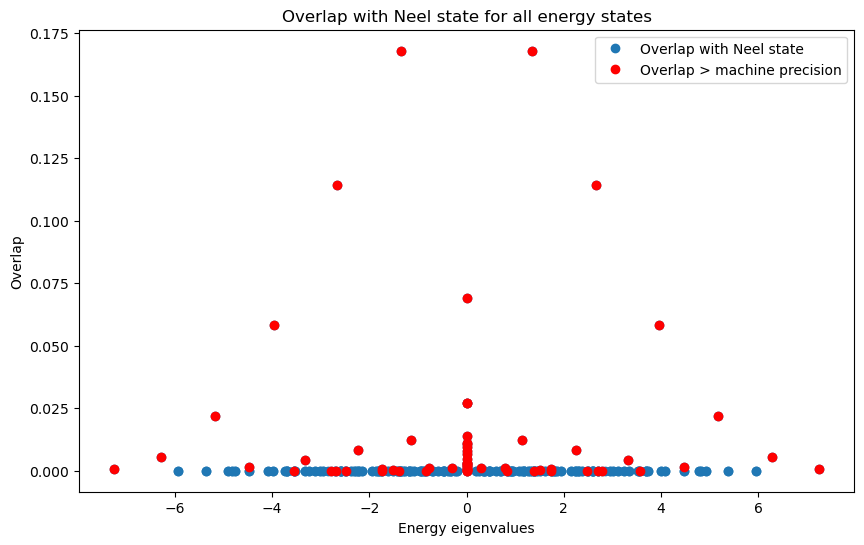

C:\Users\camipolv\AppData\Local\Temp\ipykernel_8220\2829388911.py:17: RuntimeWarning: divide by zero encountered in log10
  plt.plot(eigenvalues, np.log10(overlaps), 'o', label='Log of overlap with Neel state')


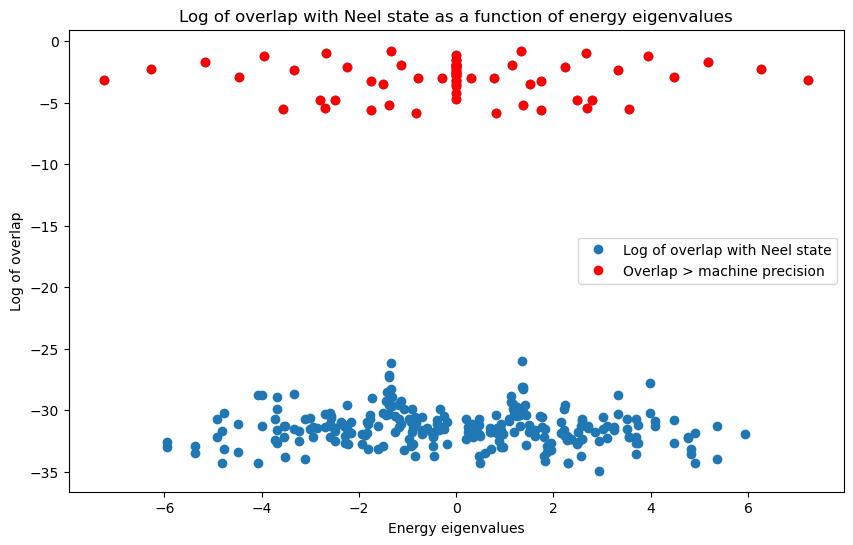

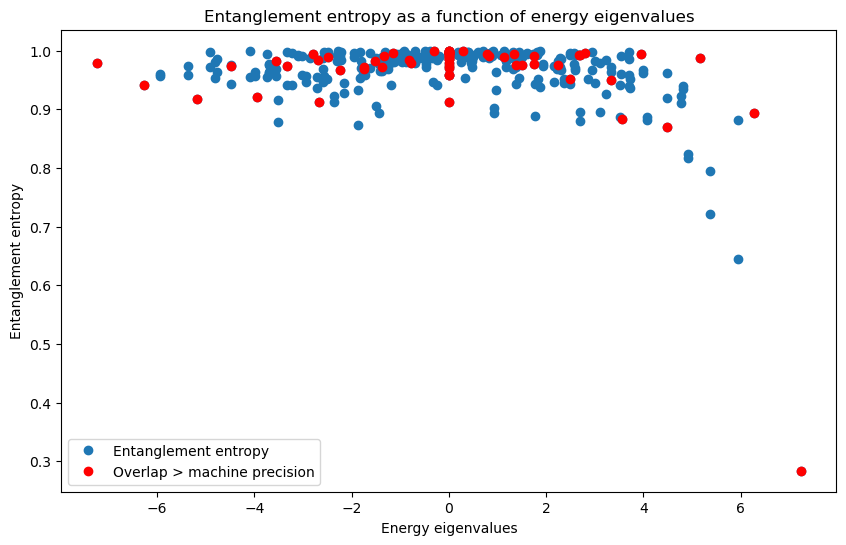

In [ ]:
# ALL PLOTS IN THE ALLOWED HILBERT SUBSPACE

# Identify indices where overlap is greater than machine precision
machine_epsilon = np.finfo(float).eps
highlight_indices = overlaps > machine_epsilon

# Plot overlap with Neel state for all energy states
plt.figure(figsize=(10, 6))
plt.plot(eigenvalues, overlaps, 'o', label='Overlap with Neel state')
plt.plot(np.array(eigenvalues)[highlight_indices], np.array(overlaps)[highlight_indices], 'ro', label='Overlap > machine precision')
plt.xlabel('Energy eigenvalues')
plt.ylabel('Overlap')
plt.title('Overlap with Neel state for all energy states')
plt.legend()
plt.show()

# Plot log of overlap as a function of energy eigenvalues
plt.figure(figsize=(10, 6))
plt.plot(eigenvalues, np.log10(overlaps), 'o', label='Log of overlap with Neel state')
plt.plot(np.array(eigenvalues)[highlight_indices], np.log10(np.array(overlaps)[highlight_indices]), 'ro', label='Overlap > machine precision')
plt.xlabel('Energy eigenvalues')
plt.ylabel('Log of overlap')
plt.title('Log of overlap with Neel state as a function of energy eigenvalues')
plt.legend()
plt.show()

# Plot entanglement entropy as a function of energy eigenvalues
plt.figure(figsize=(10, 6))
plt.plot(eigenvalues, entropies, 'o', label='Entanglement entropy')
plt.plot(np.array(eigenvalues)[highlight_indices], np.array(entropies)[highlight_indices], 'ro', label='Overlap > machine precision')
plt.xlabel('Energy eigenvalues')
plt.ylabel('Entanglement entropy')
plt.title('Entanglement entropy as a function of energy eigenvalues')
plt.legend()
plt.show()

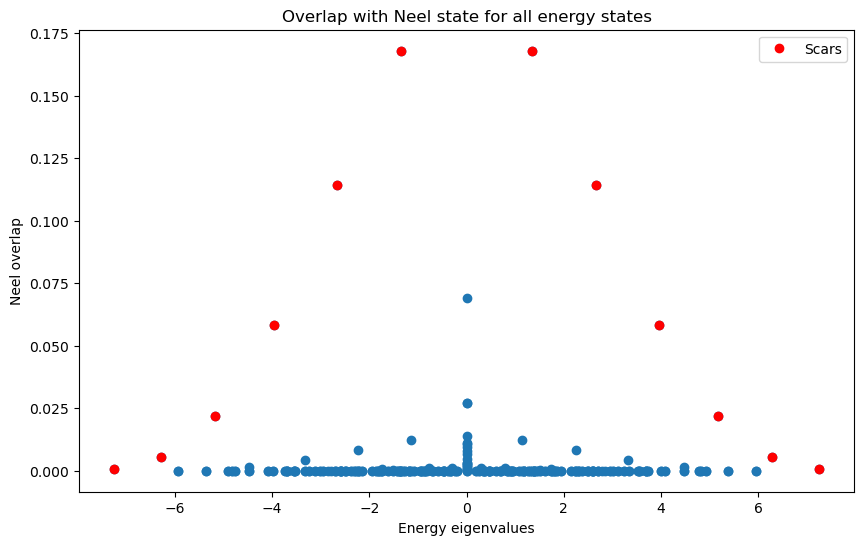

C:\Users\camipolv\AppData\Local\Temp\ipykernel_8220\2468072960.py:38: RuntimeWarning: divide by zero encountered in log10
  plt.plot(eigenvalues, np.log10(overlaps), 'o')


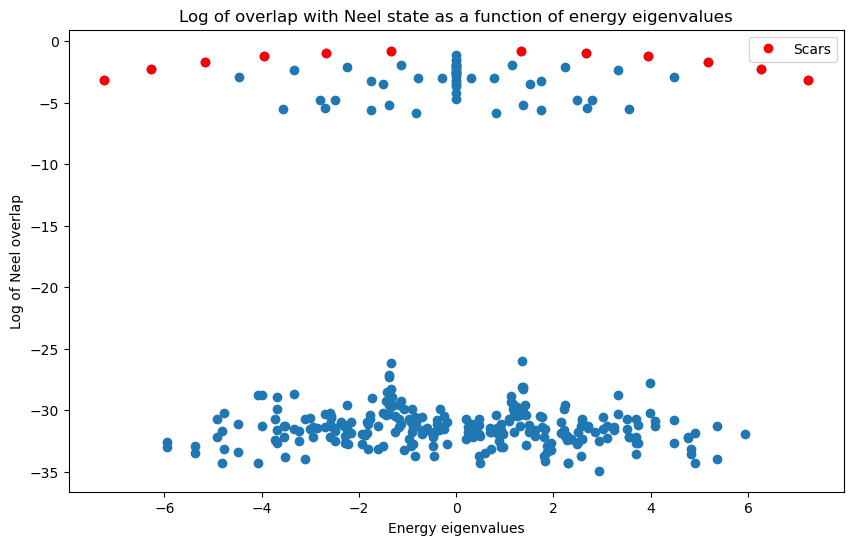

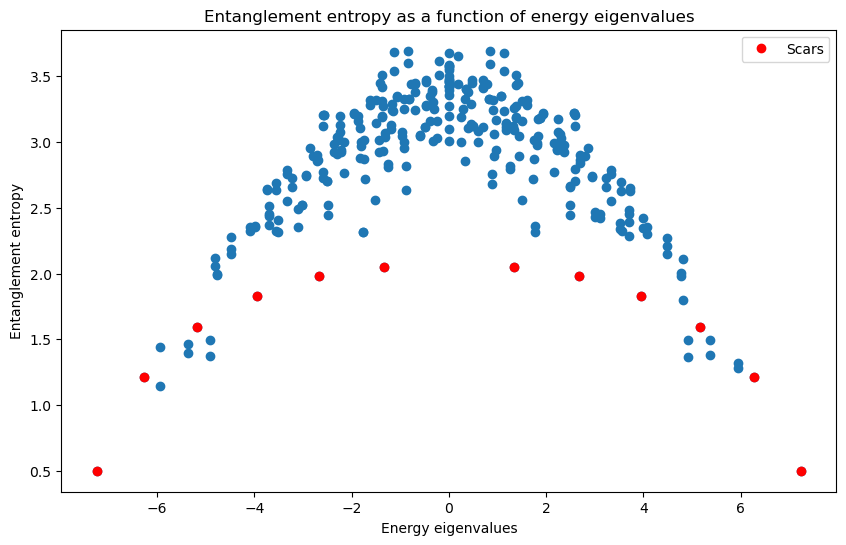

In [ ]:
# NEEL OVERLAP PLOT IN THE ALLOWED HILBERT SUBSPACE, ENTROPY PLOT IN THE FULL HILBERT SPACE

# Identify indices where overlap is greater than machine precision and energy is not zero
machine_epsilon = np.finfo(float).eps
highlight_indices = (overlaps > machine_epsilon) & (np.abs(eigenvalues) > machine_epsilon)

# Define a function for the curves
def sfunc(x, a, b):
    return a * (x)**2 + b

# Define the two curves 
# CURVES COEFFS SPECIFIC TO THE DATA WITH N=12
curve1 = sfunc(eigenvalues, -0.025, 2.4)
curve2 = sfunc(eigenvalues, -0.03, 1.9)

# Identify indices where entropies are between the two curves
between_curves_indices = (entropies > curve2) & (entropies < curve1)

# Combine the conditions
highlight_between_curves_indices = highlight_indices & between_curves_indices

# Fit the red points only
x_data = np.array(eigenvalues)[highlight_between_curves_indices]
y_data = np.array(entropies)[highlight_between_curves_indices]
popt, pcov = curve_fit(sfunc, x_data, y_data)

# Plot overlap with Neel state for all energy states
plt.figure(figsize=(10, 6))
plt.plot(eigenvalues, overlaps, 'o')
#plt.plot(np.array(eigenvalues)[highlight_indices], np.array(overlaps)[highlight_indices], 'ro', label='Overlap > machine precision')
plt.plot(np.array(eigenvalues)[highlight_between_curves_indices], np.array(overlaps)[highlight_between_curves_indices], 'ro', label='Scars')
plt.xlabel('Energy eigenvalues')
plt.ylabel('Neel overlap')
plt.title('Overlap with Neel state for all energy states')
plt.legend()
plt.show()

# Plot log of overlap as a function of energy eigenvalues
plt.figure(figsize=(10, 6))
plt.plot(eigenvalues, np.log10(overlaps), 'o')
#plt.plot(np.array(eigenvalues)[highlight_indices], np.log10(np.array(overlaps)[highlight_indices]), 'ro', label='Overlap > machine precision')
plt.plot(np.array(eigenvalues)[highlight_between_curves_indices], np.log10(np.array(overlaps)[highlight_between_curves_indices]), 'ro', label='Scars')
plt.xlabel('Energy eigenvalues')
plt.ylabel('Log of Neel overlap')
plt.title('Log of overlap with Neel state as a function of energy eigenvalues')
plt.legend()
plt.show()

'''# Plot entanglement entropy as a function of energy eigenvalues
plt.figure(figsize=(10, 6))
plt.plot(eigenvalues, entropies, 'o', label='Entanglement entropy')
#plt.plot(np.array(eigenvalues)[highlight_indices], np.array(entropies)[highlight_indices], 'ro', label='Overlap > machine precision')
plt.plot(np.array(eigenvalues)[highlight_between_curves_indices], np.array(entropies)[highlight_between_curves_indices], 'ro', label='Scars')
plt.xlabel('Energy eigenvalues')
plt.ylabel('Entanglement entropy')
plt.title('Entanglement entropy as a function of energy eigenvalues')
plt.legend()
plt.show()'''

# Plot entanglement entropy as a function of energy eigenvalues with curves
plt.figure(figsize=(10, 6))
plt.plot(eigenvalues, entropies, 'o')
plt.plot(np.array(eigenvalues)[highlight_between_curves_indices], np.array(entropies)[highlight_between_curves_indices], 'ro', label='Scars')
#plt.plot(eigenvalues, curve1, 'r-', label='Curve 1: -0.025 * x^2 + 2.4')
#plt.plot(eigenvalues, curve2, 'r-', label='Curve 2: -0.03 * x^2 + 1.9')

# Plot the fitted curve
x_fit = np.linspace(min(x_data), max(x_data), 100)
y_fit = sfunc(x_fit, *popt)
#plt.plot(x_fit, y_fit, 'r-', label='Fitted curve')

plt.xlabel('Energy eigenvalues')
plt.ylabel('Entanglement entropy')
plt.title('Entanglement entropy as a function of energy eigenvalues')
plt.legend()
plt.show()

In [ ]:
# Compute the rank of the RDM for the scar points only

for i in np.where(highlight_between_curves_indices)[0]:
    full_hilbert_space_vector = full_hilbert_space_eigenvectors[:, i]
    
    # Construct the density matrix
    density_matrix = np.outer(full_hilbert_space_vector, full_hilbert_space_vector.conj())
    
    # Trace out some qubits (keep other qubits)
    dims = [2] * 12  # Assuming n_spins = 12
    keep_qubits = [0, 1, 2]  # Indices of qubits to keep
    traced_out_density_matrix = partial_trace(density_matrix, keep_qubits, dims)
    
    # Diagonalize the traced out density matrix
    to_eigenvalues, to_eigenvectors = np.linalg.eigh(traced_out_density_matrix)
    
    # Print the minimum eigenvalue
    min_eigenvalue = np.min(to_eigenvalues)
    #print(f"Eigenvector {i}: Minimum eigenvalue: {min_eigenvalue}")
    
    # Print the rank of the traced out density matrix
    rank = np.linalg.matrix_rank(traced_out_density_matrix)
    print(f"Eigenvector {i}: Rank of traced out density matrix: {rank}")

    print(f"reduced space dim with pbc is {fib_dim(len(keep_qubits), pbc=True)}")
    print(f"reduced space dim with obc is {fib_dim(len(keep_qubits), pbc=False)}")


Eigenvector 0: Rank of traced out density matrix: 5
Eigenvector 1: Rank of traced out density matrix: 5
Eigenvector 6: Rank of traced out density matrix: 5
Eigenvector 20: Rank of traced out density matrix: 5
Eigenvector 48: Rank of traced out density matrix: 5
Eigenvector 100: Rank of traced out density matrix: 5
Eigenvector 221: Rank of traced out density matrix: 5
Eigenvector 273: Rank of traced out density matrix: 5
Eigenvector 301: Rank of traced out density matrix: 5
Eigenvector 315: Rank of traced out density matrix: 5
Eigenvector 320: Rank of traced out density matrix: 5
Eigenvector 321: Rank of traced out density matrix: 5
